In [7]:
import json
import pandas as pd

# Se carga el conjunto de datos de entrenamiento desde el archivo 
df = pd.read_csv("data/train_comentario_filtered.csv")

In [13]:

# Se cuentan las etiquetas presentes.
df.label.value_counts()

0     3134
1     2460
2     1611
3     1327
4     1167
5     1127
6      957
7      655
8      538
9      513
10     510
11     392
12     361
13     307
14     273
15     268
16     268
18     237
17     235
19     228
20     226
21     207
24     201
23     199
25     198
22     195
26     171
Name: label, dtype: int64

In [11]:
16645+2910+2811+549+517+377+368+198+183

24558

In [12]:
16645/24558

0.6777832071015555

In [13]:
from pathlib import Path


from numpy import ndarray
import torch
from torch import Tensor
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from src.load_dataset import LoadDataset
from src.tokenize_dataset import TokenizeDataset

# Se define el nombre del modelo preentrenado 
model_finetuned = "nivel_3"
model_ckpt = Path(f"models/dccuchile/distilbert-base-spanish-uncased-finetuned-{model_finetuned}")

# Se carga el tokenizador y el modelo preentrenado desde archivos previamente guardados en la ruta especificada.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to(device)

class_names = list(model.config.label2id.keys())

In [14]:

#Se definen funciones para obtener las probabilidades de clasificación para un texto de entrada y para realizar inferencia y obtener la etiqueta más probable.
def _get_probabilities(text: str) -> Tensor:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.nn.functional.softmax(outputs.logits, dim=-1)

def inference(text: str) -> str:
    predictions = _get_probabilities(text).tolist()[0]

    max_vale = max(predictions)
    idx = predictions.index(max_vale)
    return model.config.id2label[idx]

In [15]:
train_dataset = f'train_{model_finetuned}_filtered.csv'
test_dataset  = f'test_{model_finetuned}_filtered.csv'

#Se definen las rutas de los archivos de datos de prueba y se cargan.
path_dataset_train = Path('data/') / train_dataset
path_dataset_test  = Path('data/') / test_dataset
with open(f'data/{model_finetuned}_categories.json', 'r') as openfile:
    CATEGORIES = json.load(openfile)
    CATEGORIES = {int(k): v for k, v in CATEGORIES.items()}
loader = LoadDataset(path_dataset_train, path_dataset_test, CATEGORIES)

train, test = loader.load_dataset()
train.dropna(inplace=True)
test.dropna(inplace=True)
dataset     = loader.create_dataset(train, test)

# Se tokeniza el conjunto de datos de prueba utilizando el tokenizador del modelo preentrenado.
tokenizer_class         = TokenizeDataset(model_ckpt)
dataset_tokenized = tokenizer_class.encoded_dataset(dataset)
dataset_tokenized.set_format("torch", 
                    columns=["input_ids", "attention_mask", "label"])

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 125.93it/s]


Dataset csv downloaded and prepared to /home/carlos/.cache/huggingface/datasets/csv/default-c04c212d8fd44909/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 278.90it/s]


In [16]:
#!pip install matplotlib
#!pip install scikit_learn==1.2.2

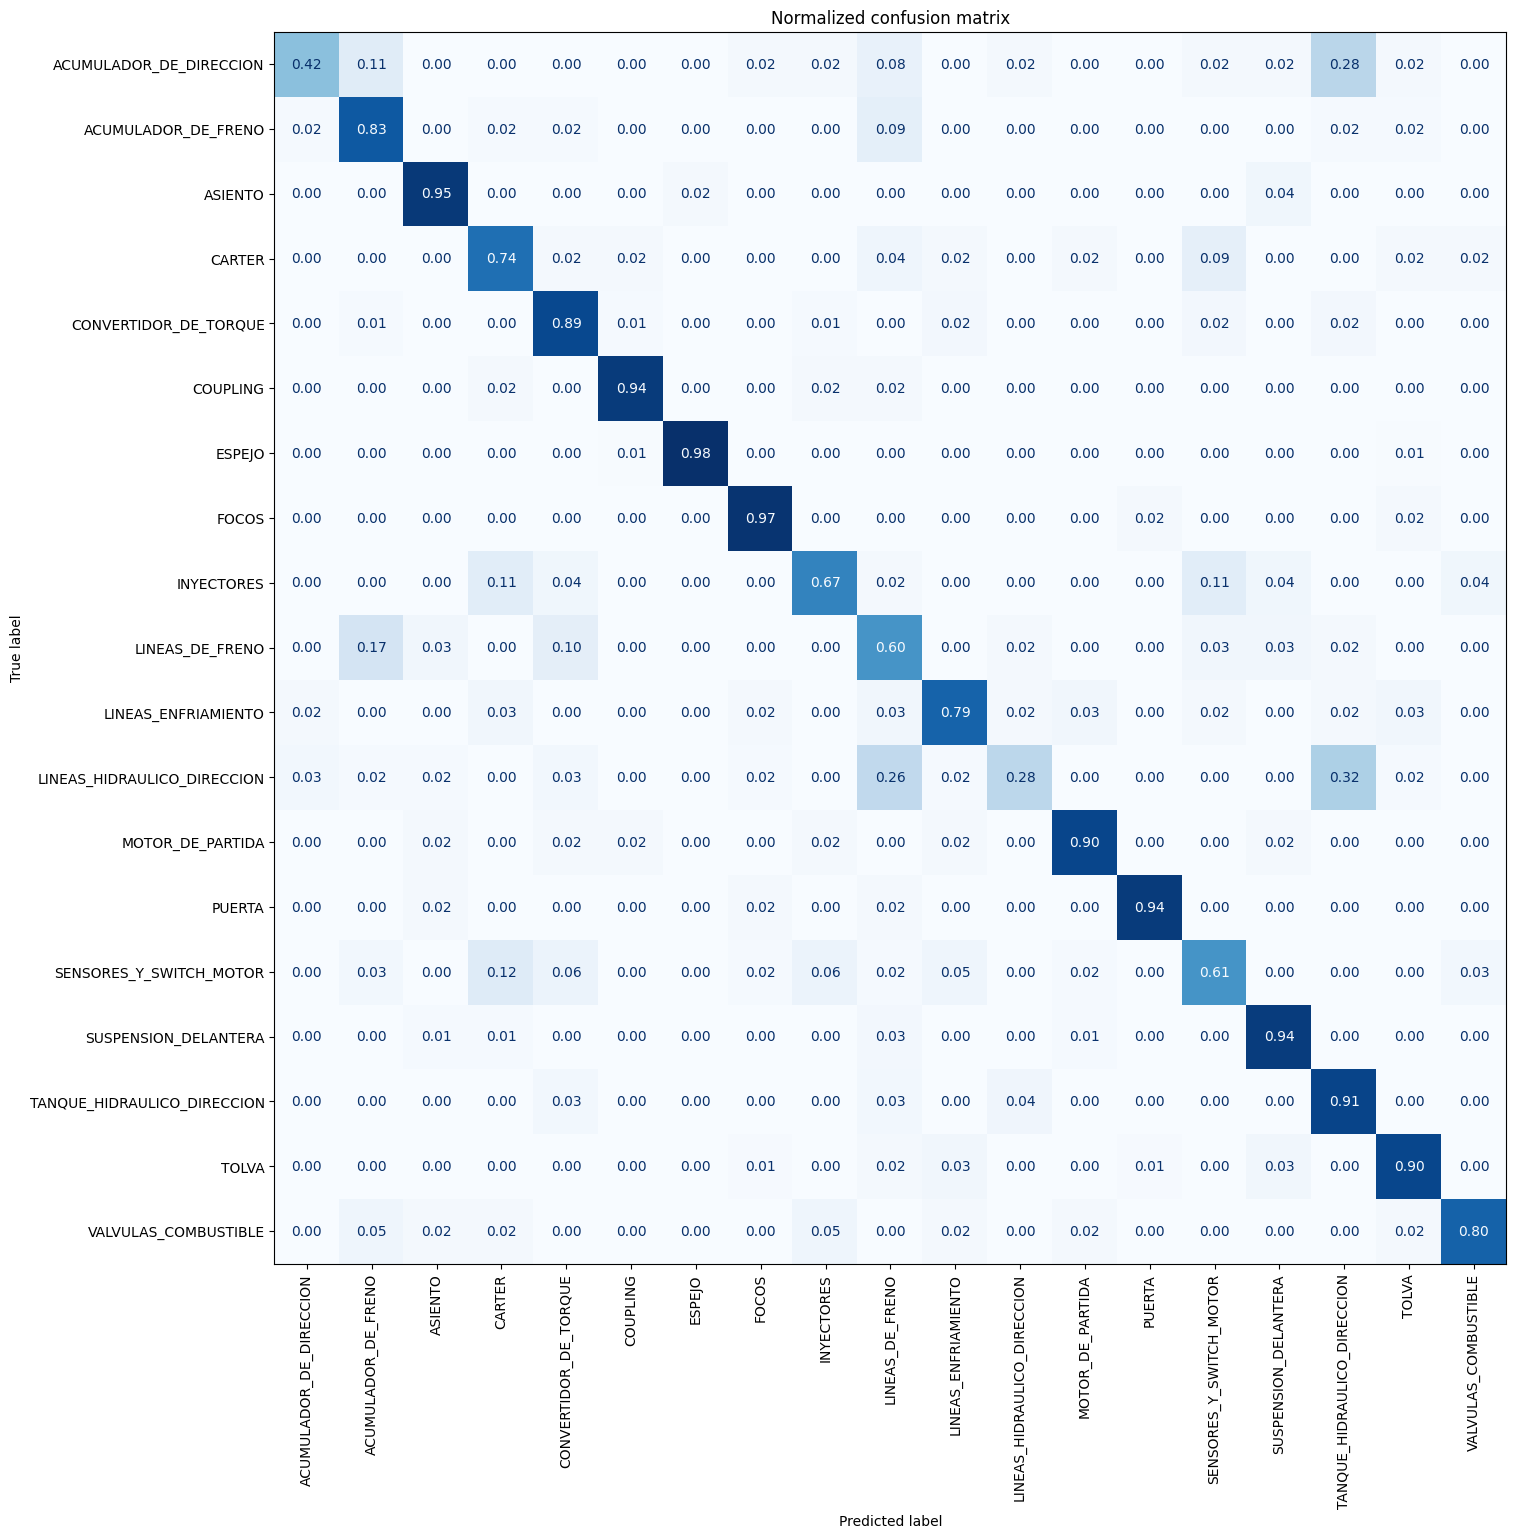

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Se crea una función que toma las predicciones y etiquetas verdaderas para generar una matriz de confusión y la muestra en un gráfico.
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(16, 16))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", xticks_rotation="vertical", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

#Se genera una matriz de confusión para evaluar el rendimiento del modelo en las etiquetas de clasificación.
y_preds = [inference(dataset_tokenized['test']['text'][i]) for i in range(len(dataset_tokenized['test']['text']))]
y_test = dataset_tokenized['test']['label_name']

plot_confusion_matrix(y_preds, y_test, class_names)

### Complete dataset

In [22]:
import pandas as pd

#Se carga un conjunto de datos completo desde el archivo "complete_test_dataset.csv" y se cuentan las etiquetas presentes.
df = pd.read_csv("data/complete_test_dataset.csv")
df.label.value_counts()

label
0    47
2    41
4    30
3    24
1    13
Name: count, dtype: int64

In [ ]:
'''
Este cuaderno de Jupyter se utiliza para cargar un modelo de clasificación de texto preentrenado, 
evaluar su rendimiento en un conjunto de datos de prueba y analizar las estadísticas de las etiquetas en los datos de prueba. 
La matriz de confusión se utiliza para visualizar el rendimiento del modelo en términos de clasificación.
'''